In [1]:
# Install catalax
# !pip install catalax

In [2]:
import catalax as ctx
import catalax.mcmc as cmc

In [3]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

# Save the model
model.save("./models/", "menten_model")

model

,name,symbol
0,s1,s1


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None



Model(
    name='Simple menten model',
    odes=DottedDict({'s1': ODE(species=Species(name='s1', symbol=s1), equation=-s1*v_max/(K_m + s1), observable=True, parameters=DottedDict({'v_max': Parameter(name='v_max', symbol=v_max, value=7.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None), 'K_m': Parameter(name='K_m', symbol=K_m, value=100.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None)}))}),
    species=,
    parameters=,
    term=None
)

/Users/janrange/GitHub/Catalax/catalax/dataset/dataset.py:542: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


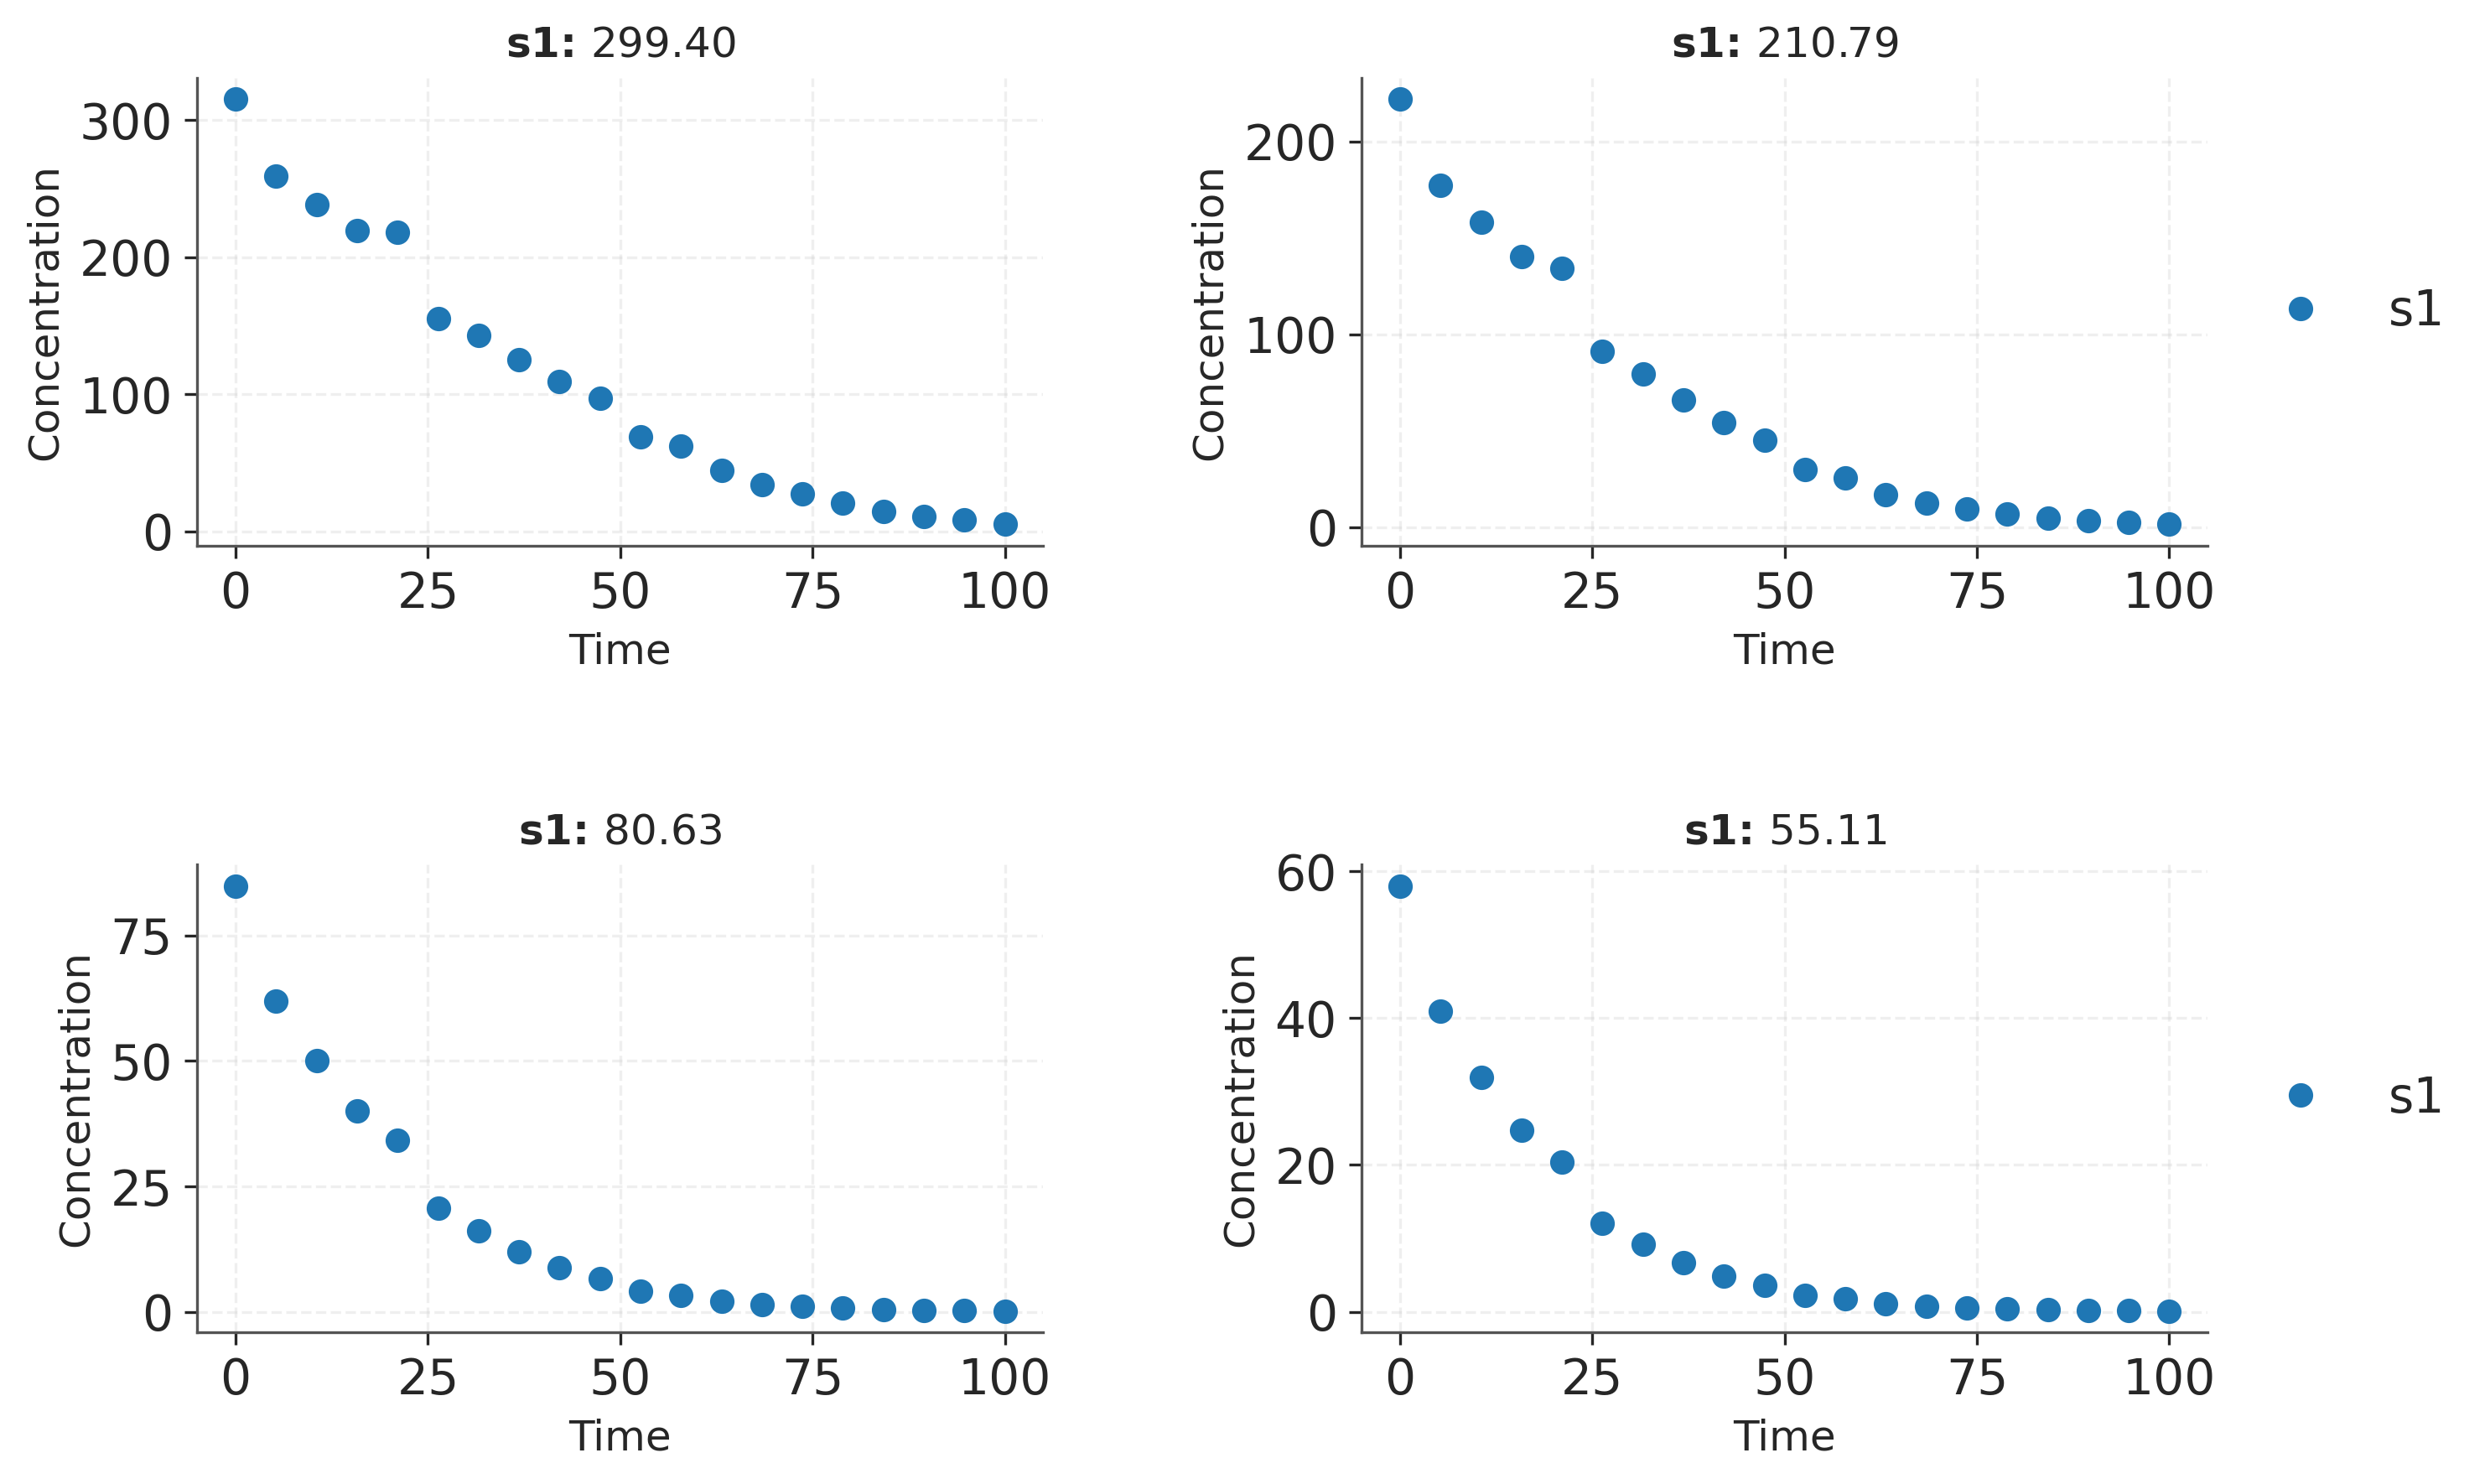

In [4]:
# Load the datasets
dataset = ctx.Dataset.from_croissant("datasets/croissant_dataset.zip")

# We need to add some noise to the data to make it more realistic
dataset = dataset.augment(n_augmentations=1, seed=0, sigma=5e-2, append=False, multiplicative=True)

f = dataset.plot(measurement_ids=[m.id for m in dataset.measurements[:4]])

In [4]:
# Define Priors
model.parameters.v_max.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.K_m.prior = cmc.priors.Uniform(low=1e-6, high=1e3)

model.parameters.v_max.prior

# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [5]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    dataset=dataset,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64 ** 4
)


🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [01:41<00:00, 19.74it/s, 15 steps of size 4.08e-01. acc. prob=0.94] 




🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    103.47      1.83    103.46    100.51    106.48    572.43      1.00
     sigma      5.02      0.07      5.02      4.90      5.13    464.58      1.00
     v_max      7.10      0.05      7.11      7.01      7.19    580.51      1.00

Number of divergences: 0


In [6]:
# Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue

    model.parameters[param].value = float(samples.mean())

model.parameters

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,103.468269,False,None,None,None,None
1,v_max,v_max,7.104021,False,None,None,None,None


<class 'catalax.model.utils.PrettyDict'>.__repr__ returned empty string

/Users/janrange/anaconda3/envs/catalax/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


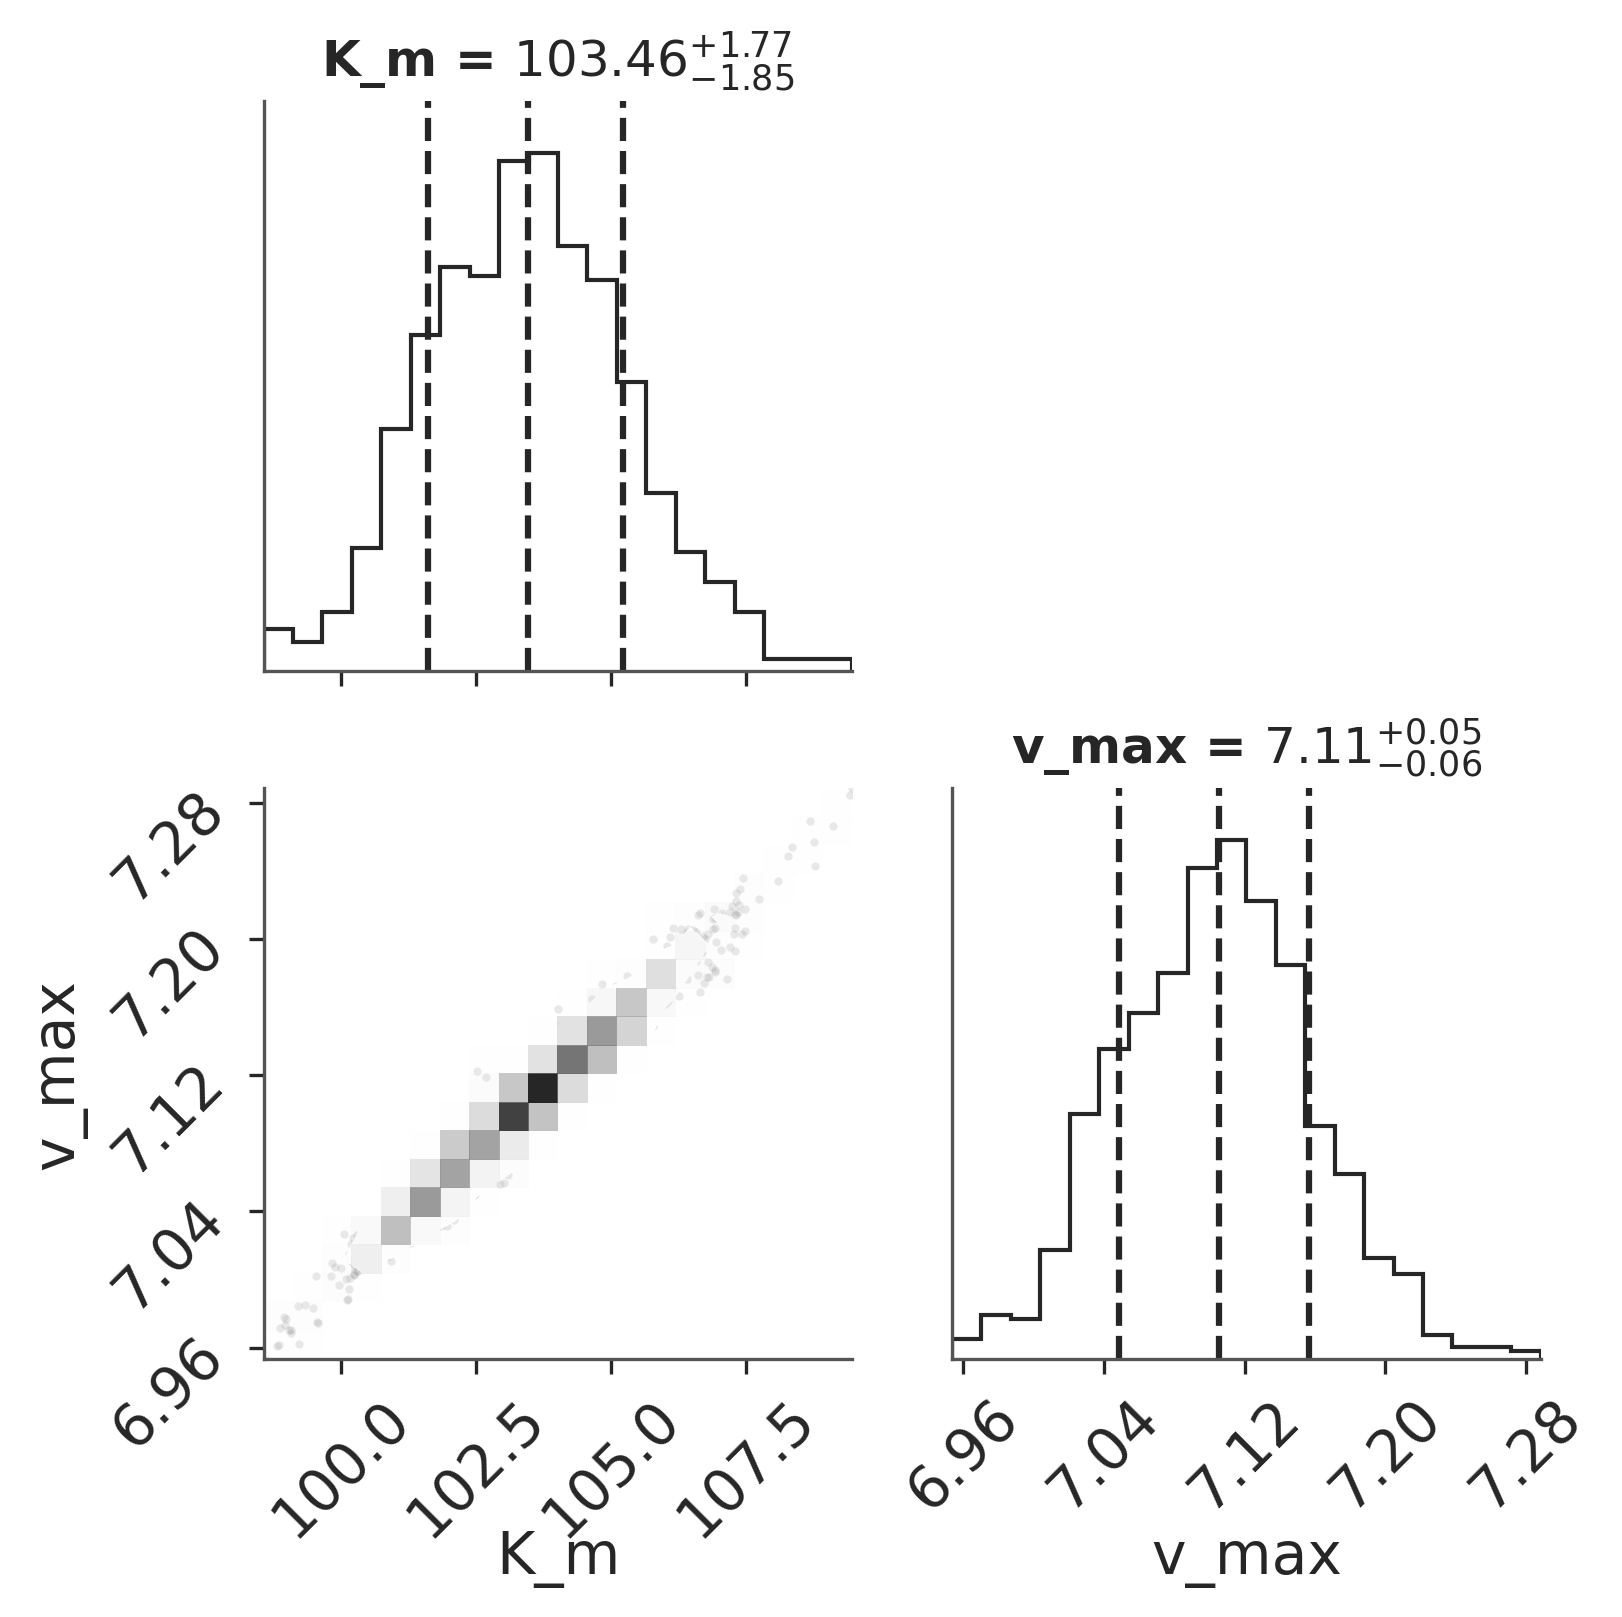

In [7]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


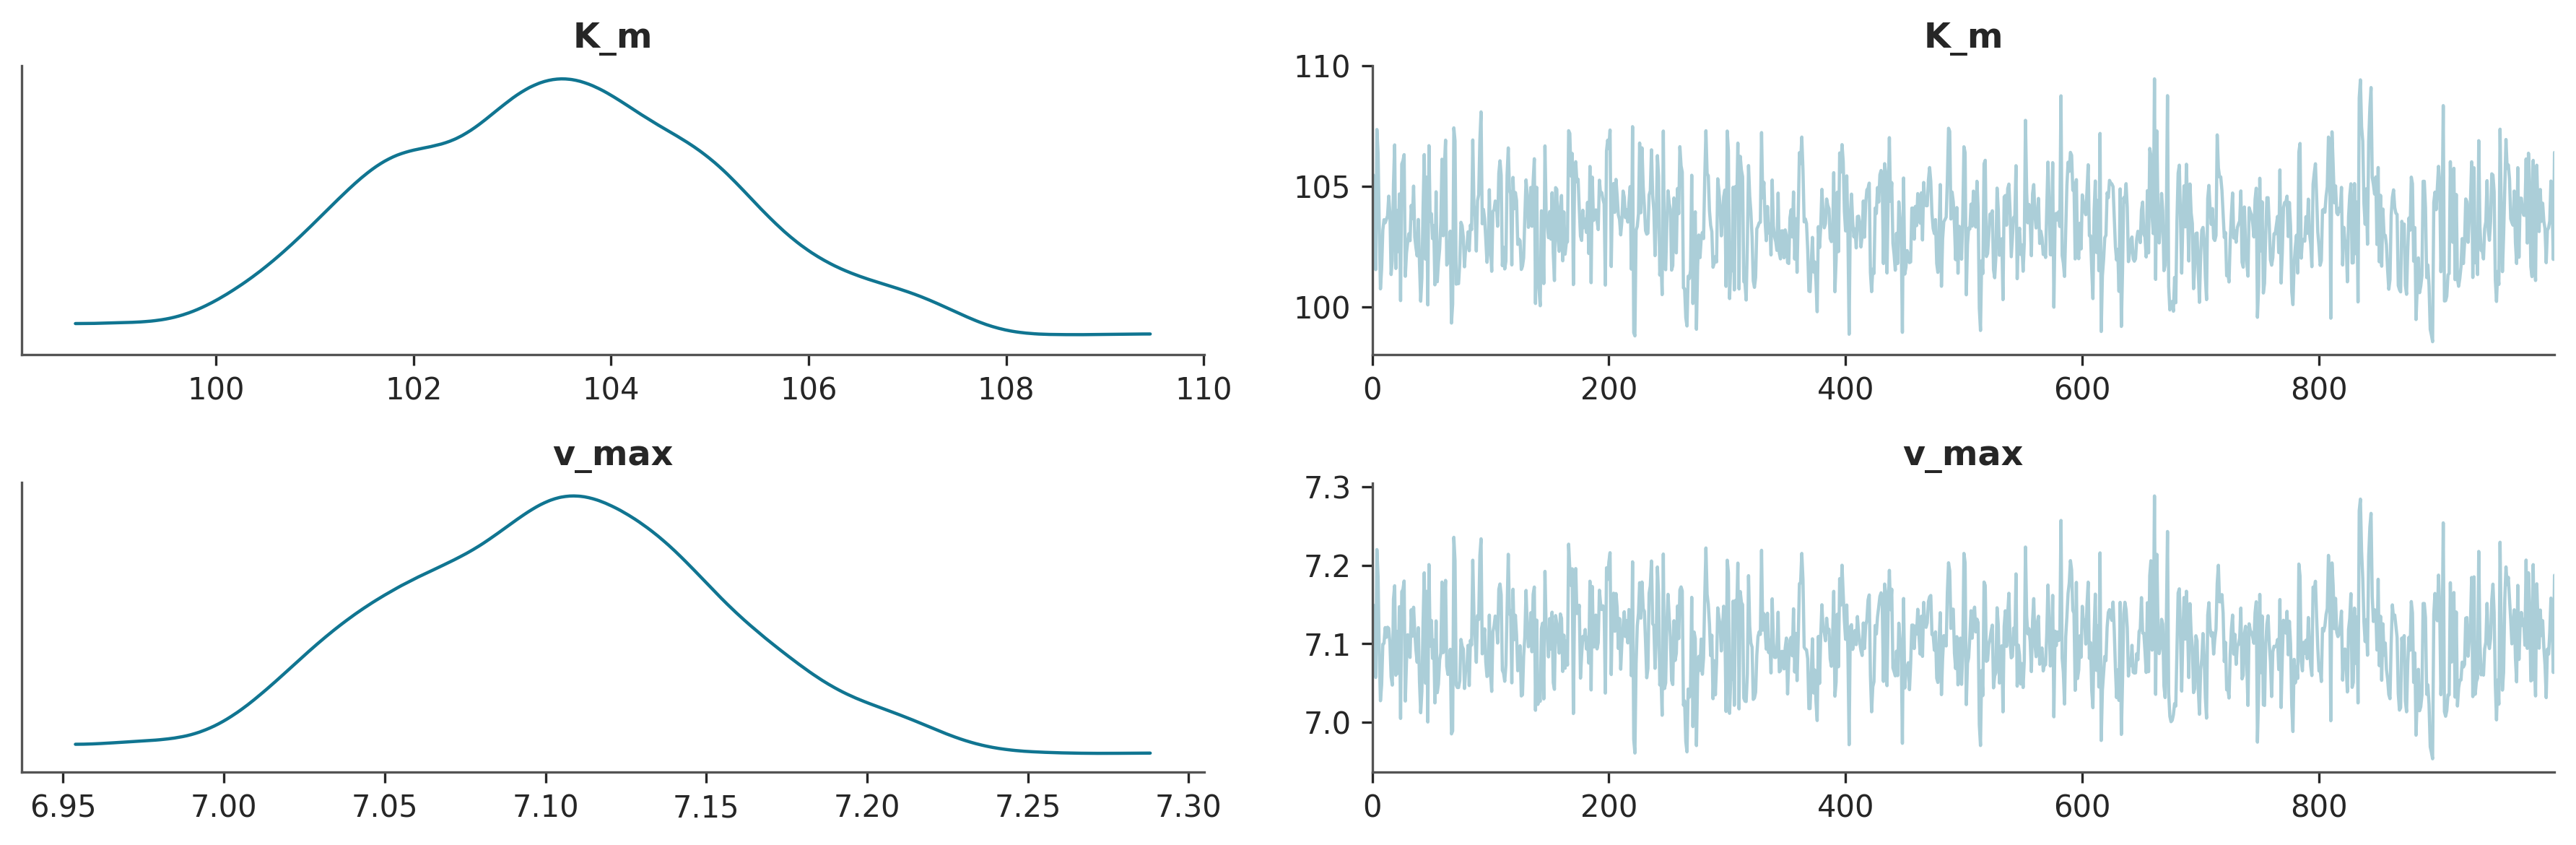

In [8]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

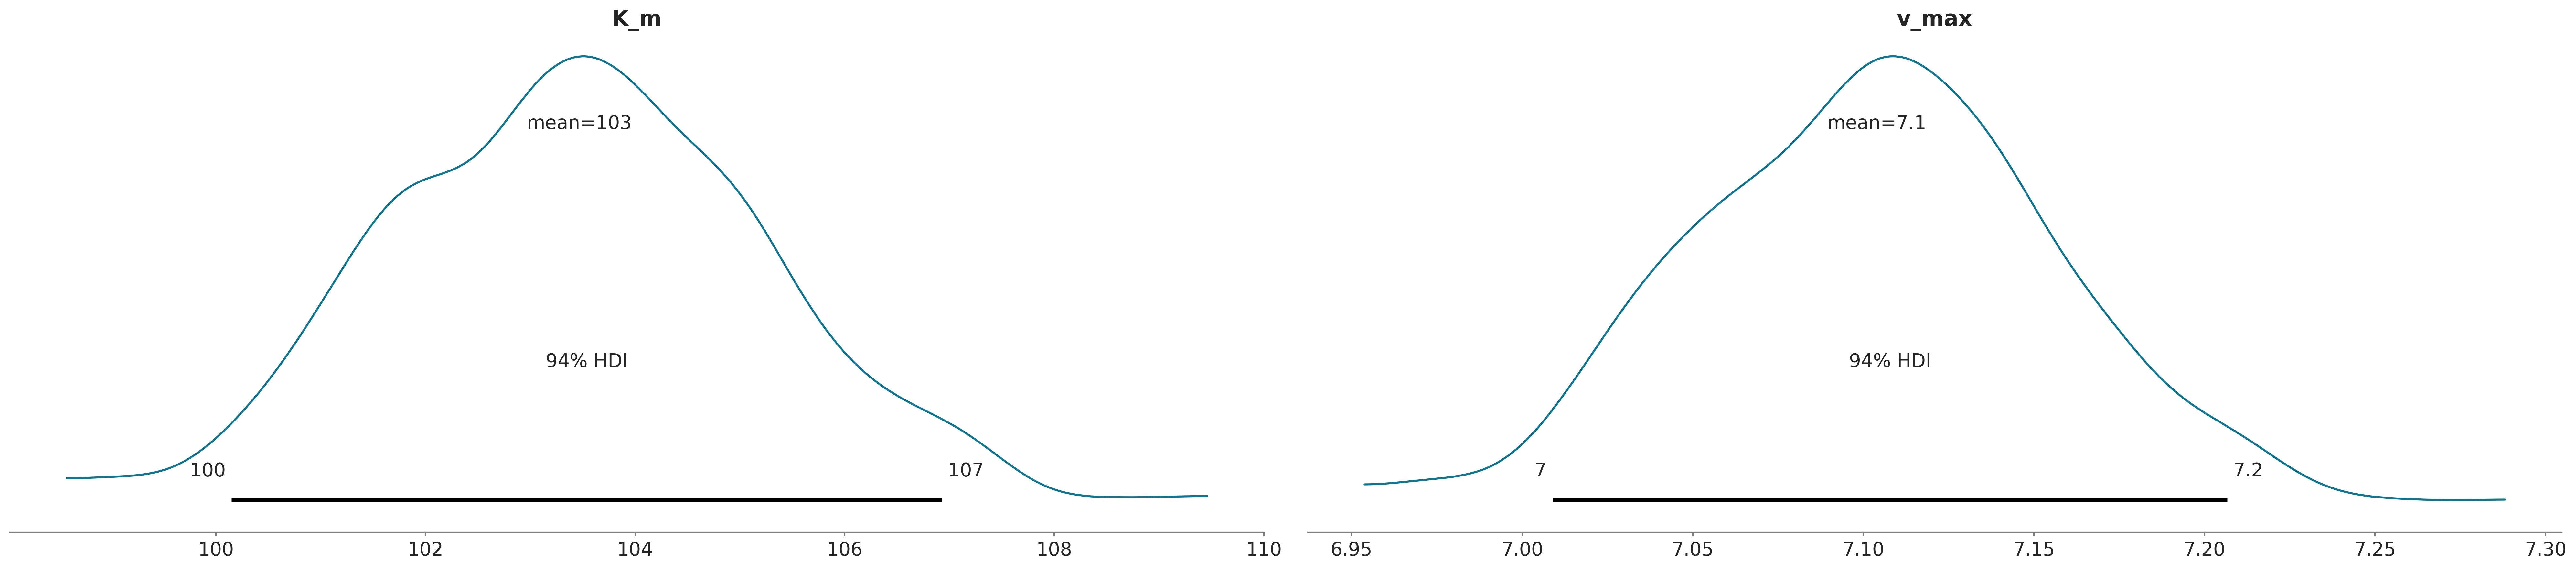

In [9]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

/Users/janrange/GitHub/Catalax/catalax/dataset/dataset.py:542: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


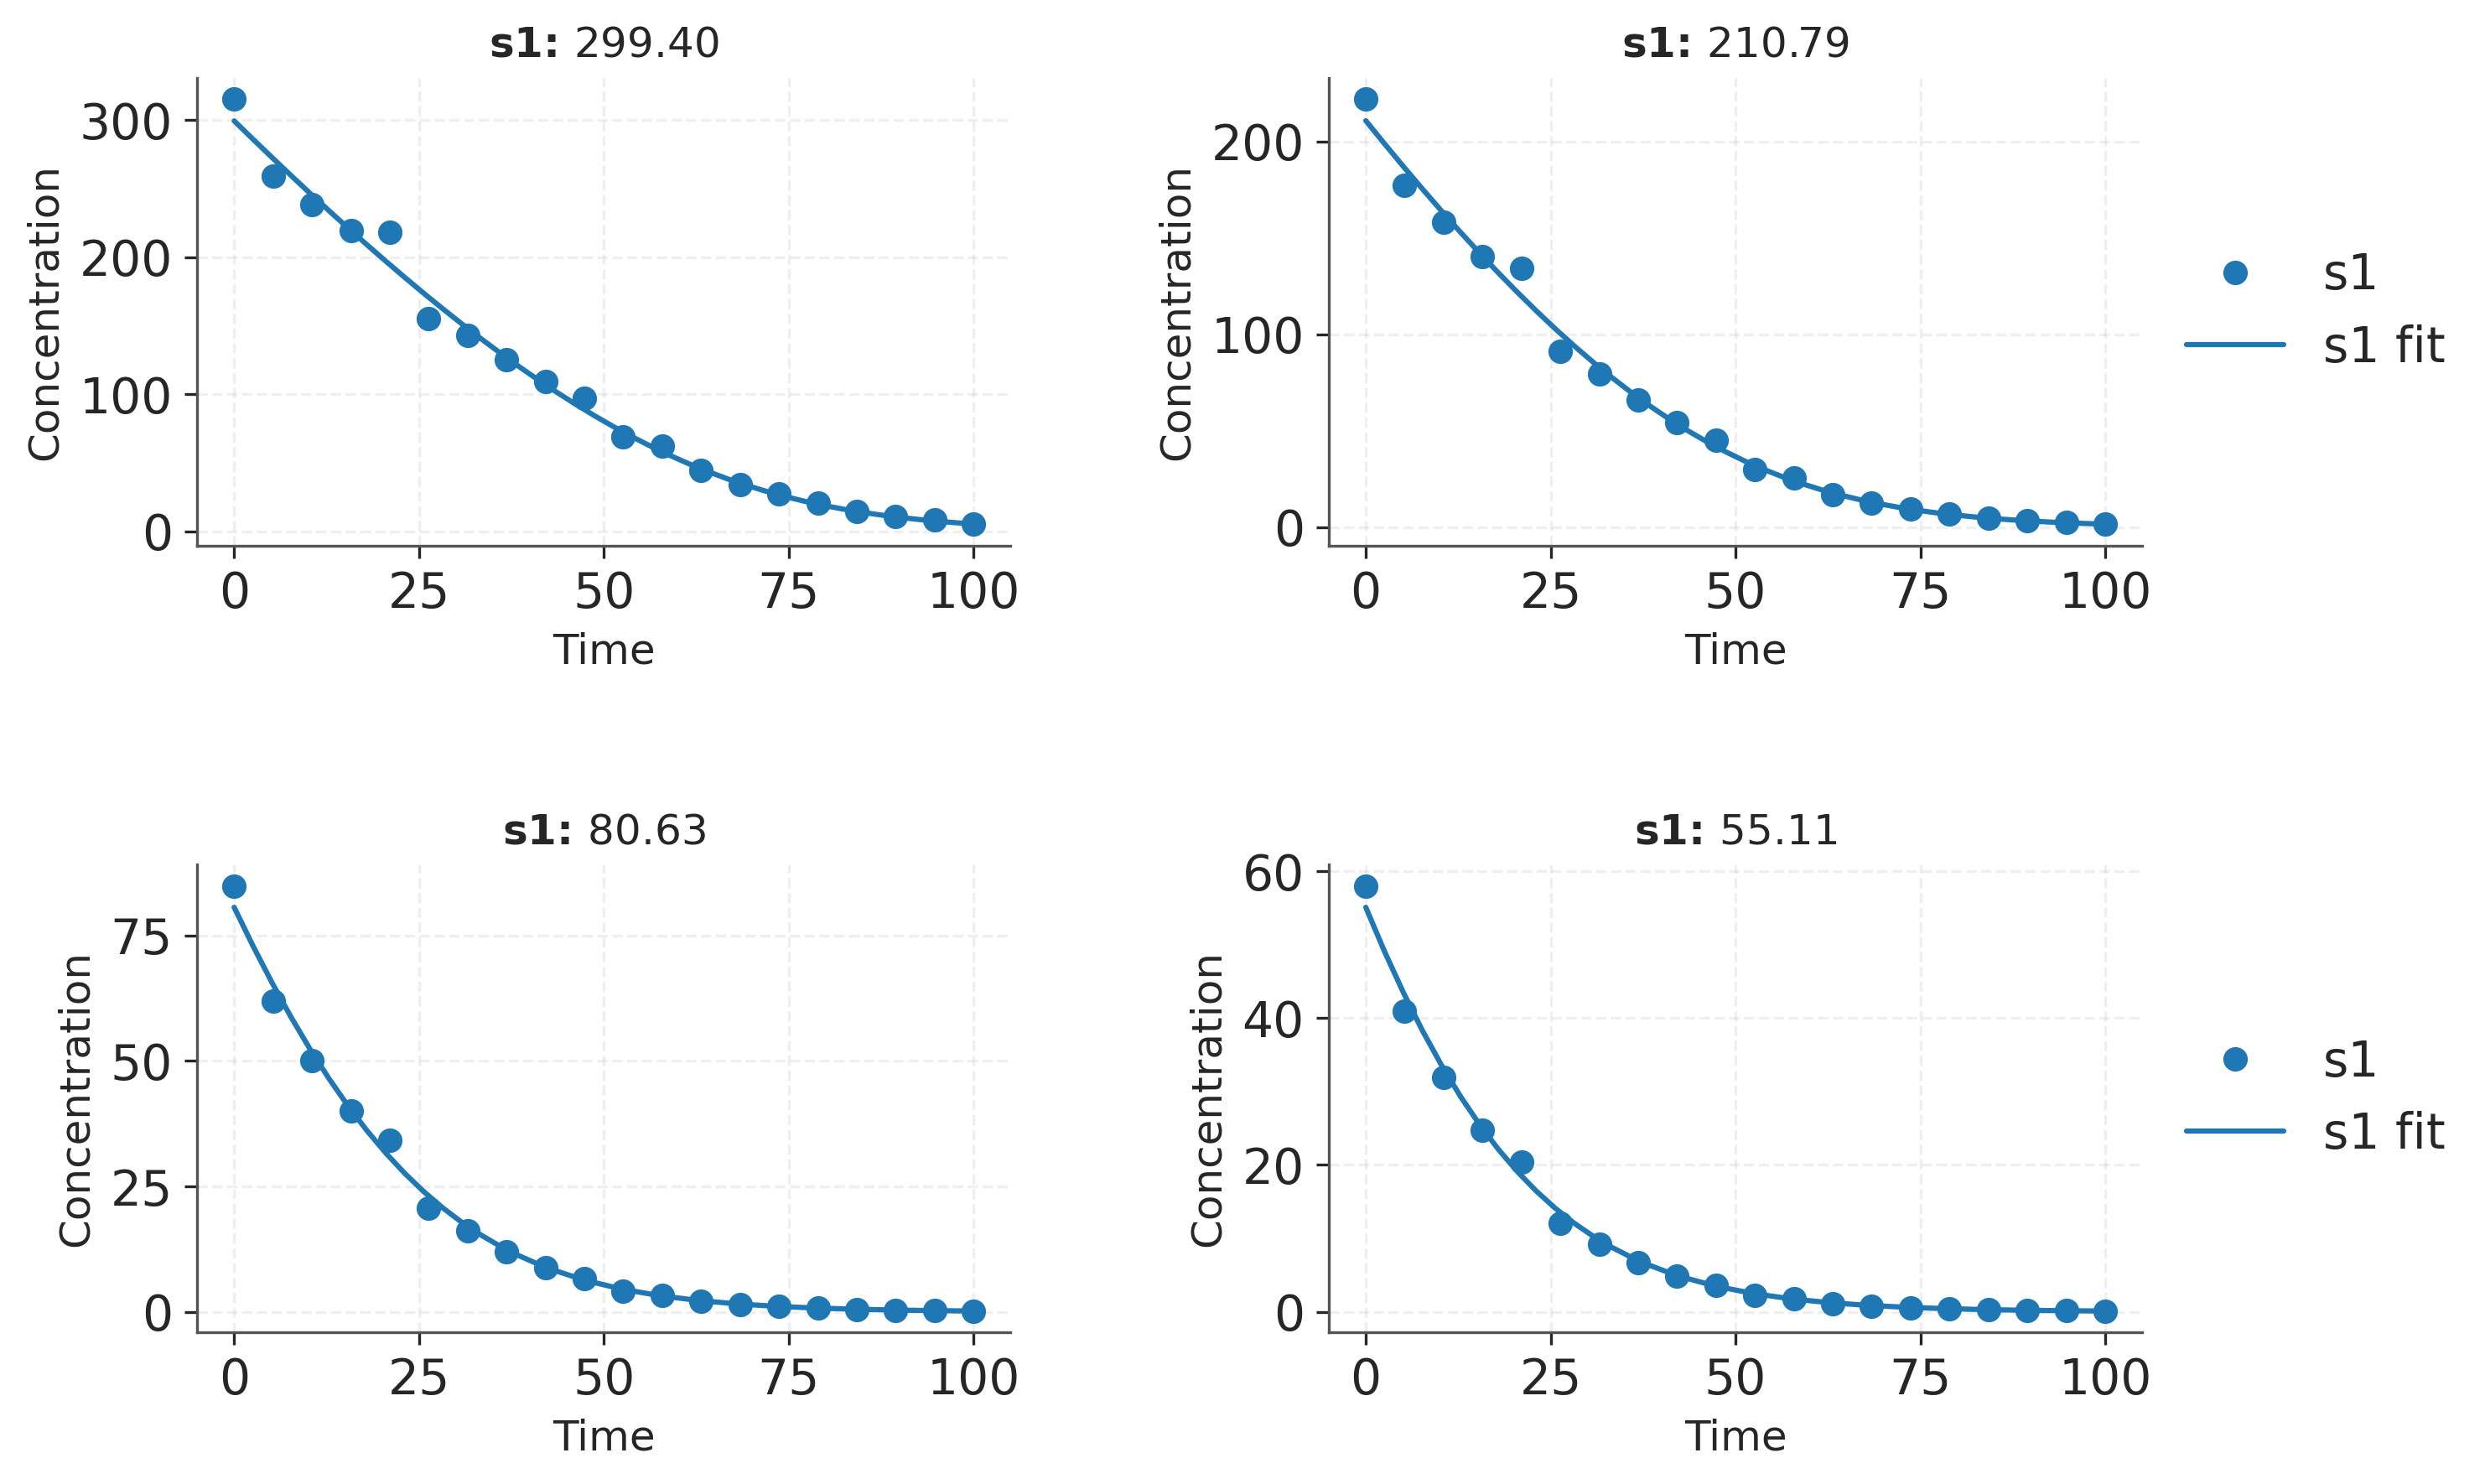

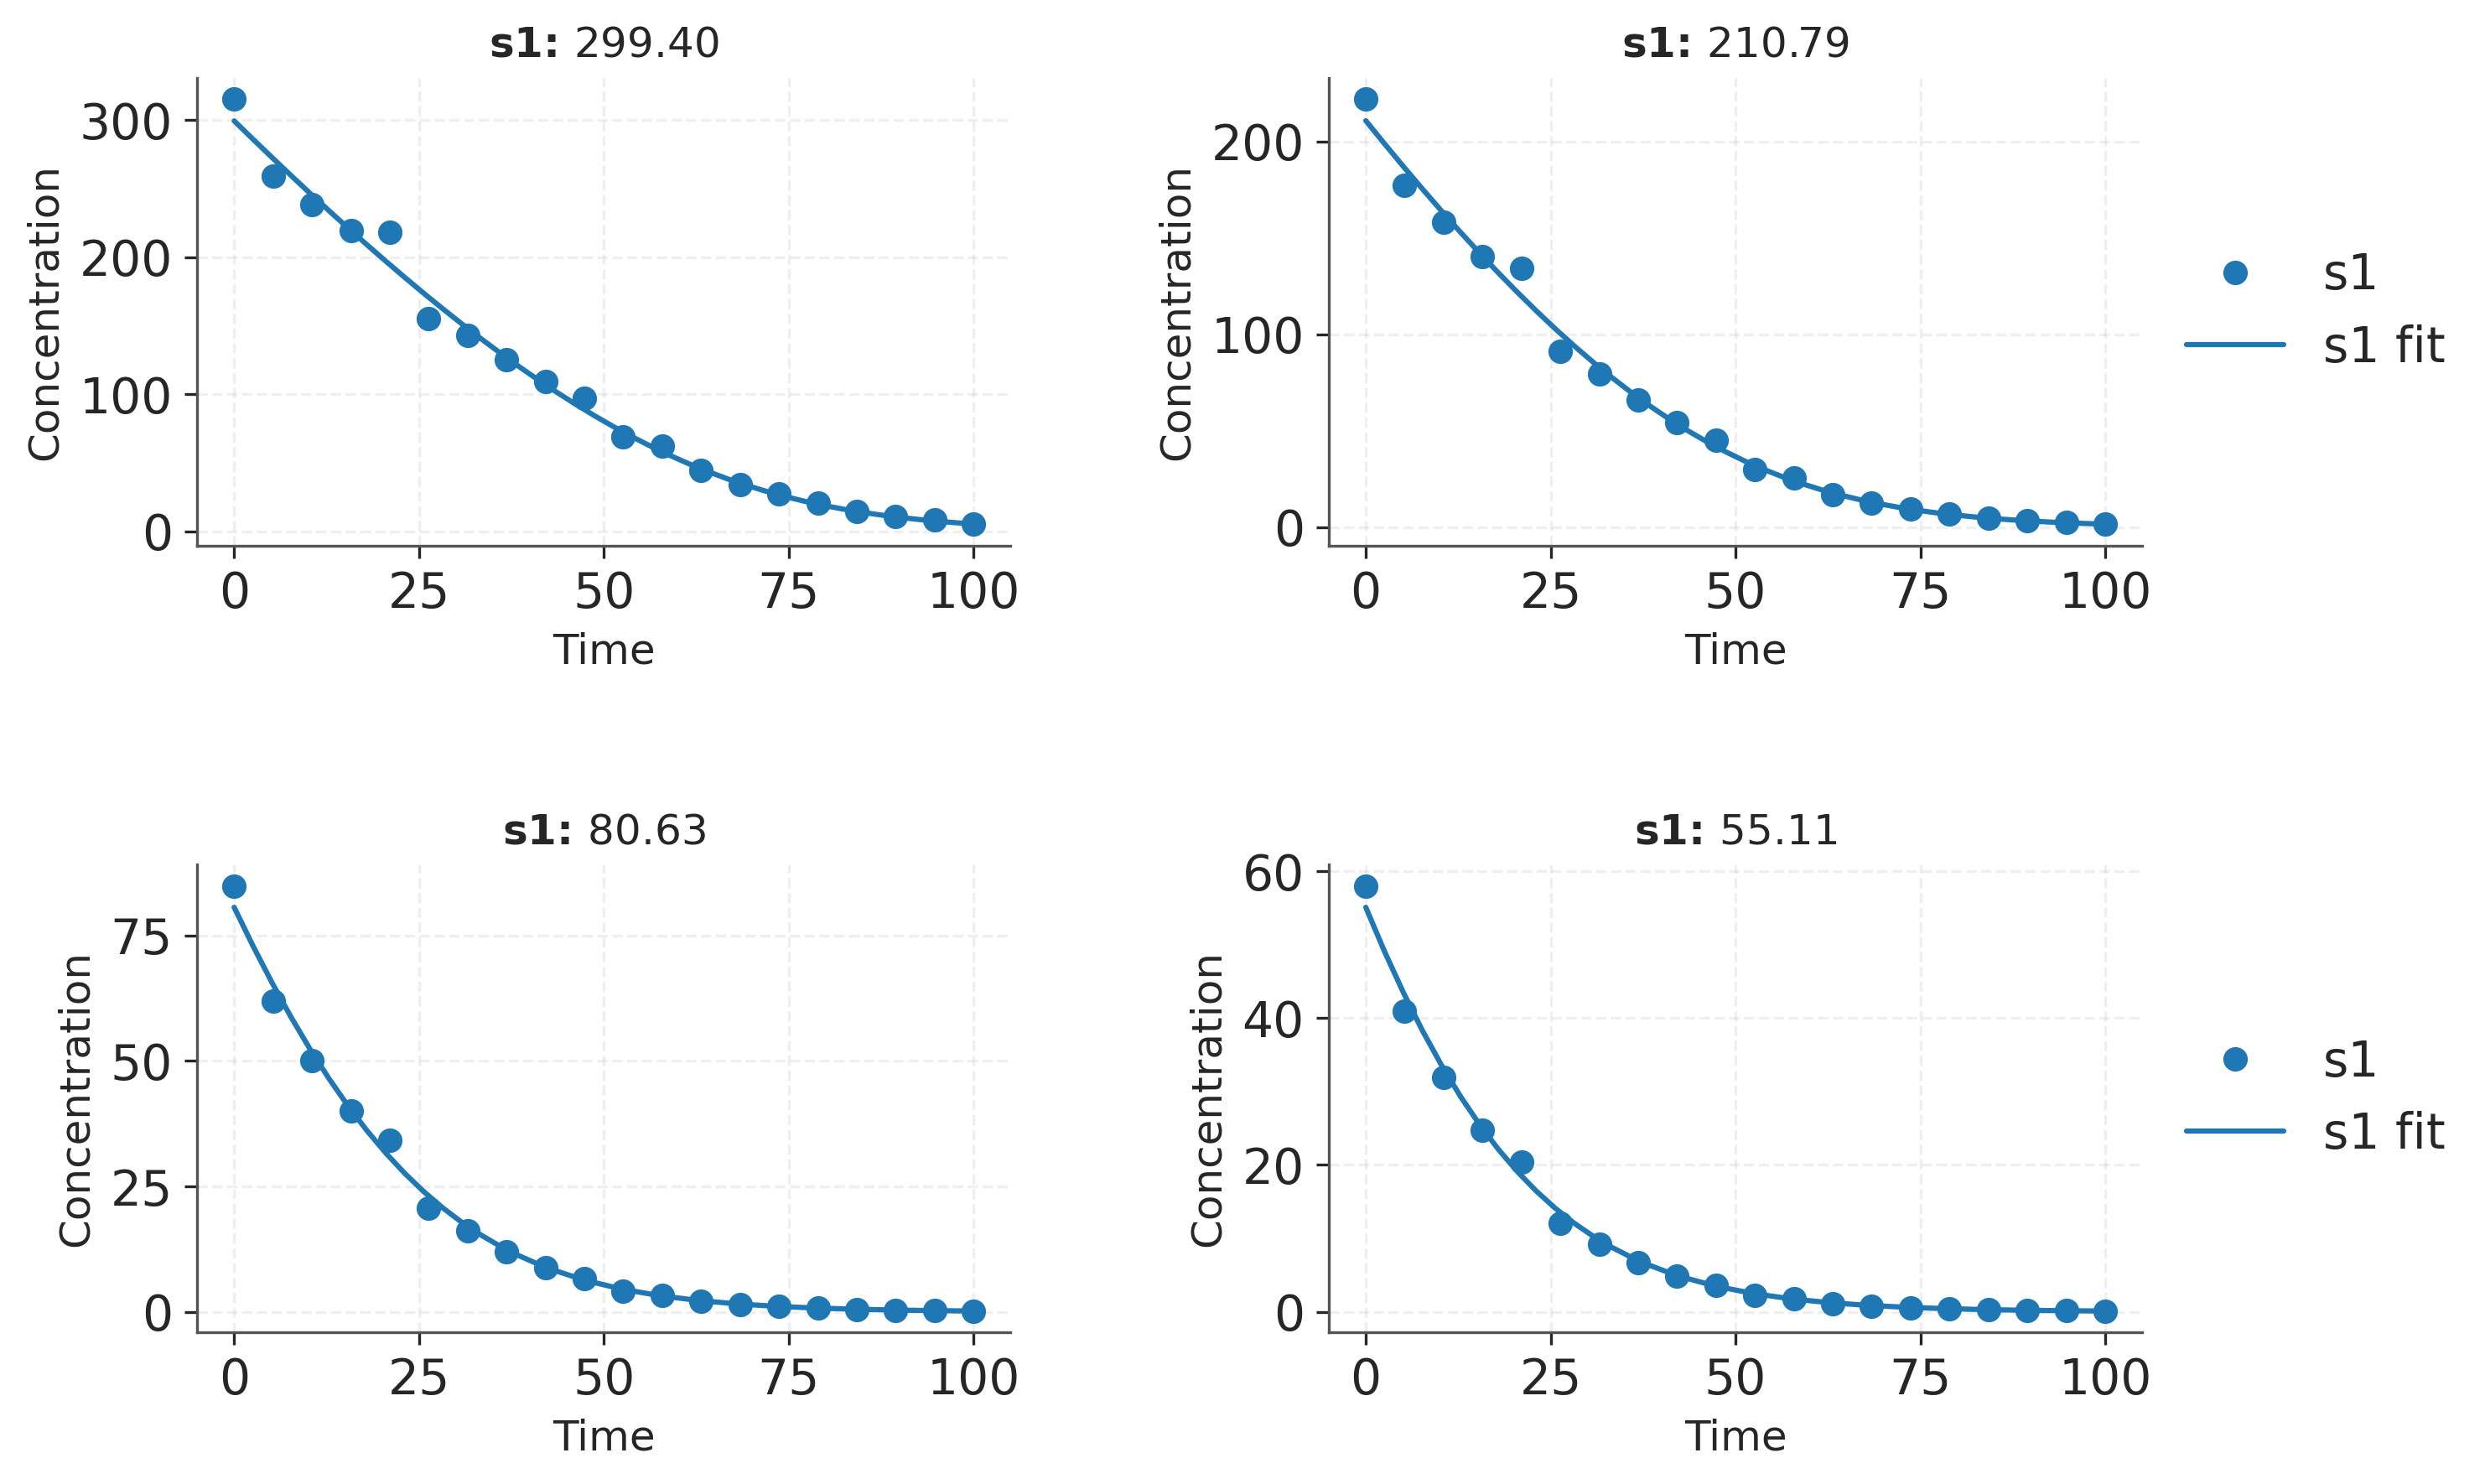

In [11]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       
#      data = np.random.normal(data, 15.0).clip(min=0)
#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


dataset.plot(model=model, measurement_ids=[m.id for m in dataset.measurements[:4]])